In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
from tabulate import tabulate

In [2]:
# read dataset
df = pd.read_csv("Dataset/lead_scoring/Leads.csv")

In [3]:
# preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)
# drop id
df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# drop columns with only 1 distinct value
cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
x = df[cat_cols].nunique()
cols_to_drop = list(x[x < 2].index)
df.drop(cols_to_drop, axis = 1, inplace = True)

# replace select to null value (later will change to Unknown)
df.replace('Select', '', inplace=True)

target = df['Converted']
df = df.drop(columns=['Converted'])

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [4]:
# split dataset
X = df
y = target
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=30)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=30)

In [5]:
# storing performance result
performance_result = [
    ["Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "Duration"]
]

In [6]:
# function for performance metrics
def print_performance(y_test, y_pred, model, et, st):
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Converted', 'Converted'],
                yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    performance_result.append([model, accuracy, precision, recall, f1, et - st])

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Duration (s): {et-st}")

In [7]:
# cross validation functions
def model_cross_validation(model, name, X_training):
    cv_scores = cross_validate(model, X_training, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    cv_results_df = pd.DataFrame({
        "Fold": [1, 2, 3, 4, 5],
        "Accuracy": cv_scores['test_accuracy'],
        "Precision": cv_scores['test_precision'],
        "Recall": cv_scores['test_recall'],
        "F1-Score": cv_scores['test_f1']
    })

    cv_results_df.loc["Mean"] = ["Mean Accuracy", cv_scores['test_accuracy'].mean(), cv_scores['test_precision'].mean(), cv_scores['test_recall'].mean(), cv_scores['test_f1'].mean()]
    cv_results_df.loc["Std Dev"] = ["Mean Standard Deviation", cv_scores['test_accuracy'].std(), cv_scores['test_precision'].std(), cv_scores['test_recall'].std(), cv_scores['test_f1'].std()]
    cv_results_df.to_csv(str(name) + "_cross_validation.csv", index=False)

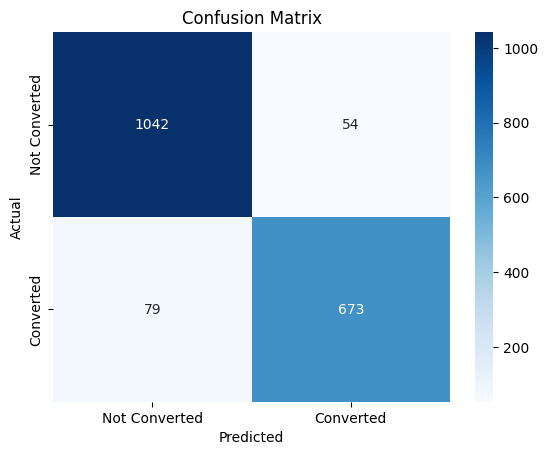

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1096
           1       0.93      0.89      0.91       752

    accuracy                           0.93      1848
   macro avg       0.93      0.92      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy: 0.928030303030303
Precision: 0.9279788276238438
Recall: 0.928030303030303
F1 Score: 0.9278278230071536
Duration (s): 0.08194828033447266


In [8]:
# lr
st = time.time()
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter = 1000))])

lr_model.fit(X_train, y_train)
et = time.time()

y_pred = lr_model.predict(X_test)

print_performance(y_test, y_pred, "LR", et, st)
model_cross_validation(lr_model, "lr", X_train)

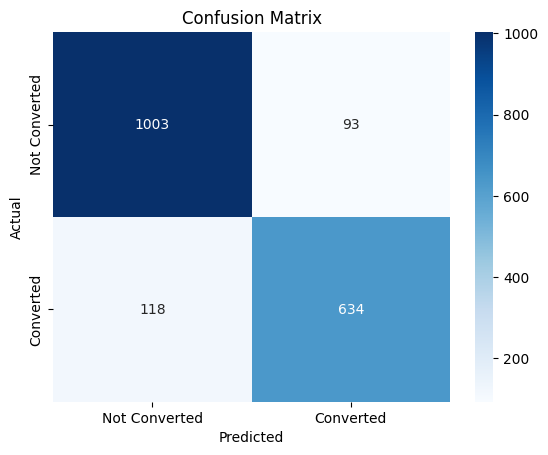

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1096
           1       0.87      0.84      0.86       752

    accuracy                           0.89      1848
   macro avg       0.88      0.88      0.88      1848
weighted avg       0.89      0.89      0.89      1848

Accuracy: 0.8858225108225108
Precision: 0.8855159657302566
Recall: 0.8858225108225108
F1 Score: 0.8855012831166121
Duration (s): 0.027508258819580078


In [9]:
# knn
st = time.time()
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)
et = time.time()

y_pred = knn_model.predict(X_test)

print_performance(y_test, y_pred, "KNN", et, st)
model_cross_validation(knn_model, "knn", X_train)

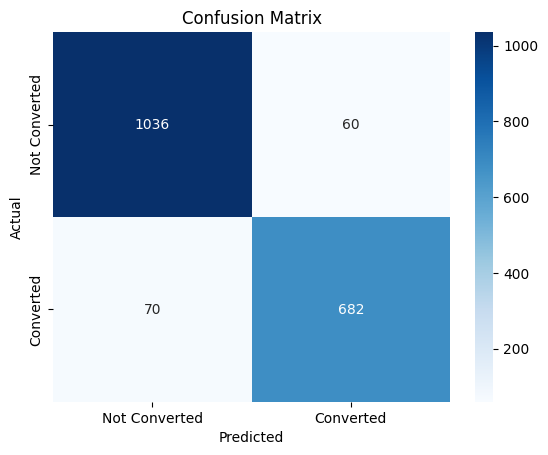

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1096
           1       0.92      0.91      0.91       752

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy: 0.9296536796536796
Precision: 0.9295585963503668
Recall: 0.9296536796536796
F1 Score: 0.9295779829905434
Duration (s): 0.8827135562896729


In [10]:
# svm
st = time.time()
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC())])

svm_model.fit(X_train, y_train)
et = time.time()

y_pred = svm_model.predict(X_test)

print_performance(y_test, y_pred, "SVM", et, st)
model_cross_validation(svm_model, "svm", X_train)

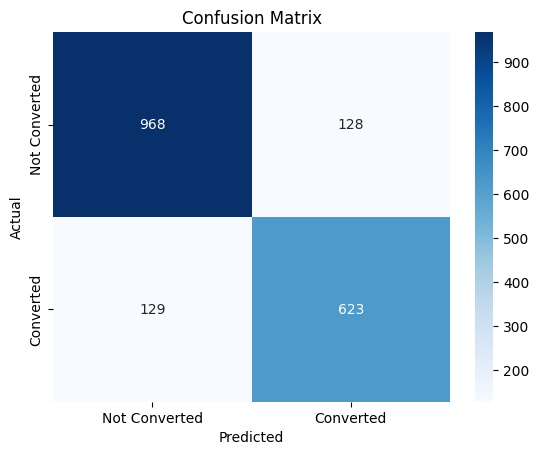

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1096
           1       0.83      0.83      0.83       752

    accuracy                           0.86      1848
   macro avg       0.86      0.86      0.86      1848
weighted avg       0.86      0.86      0.86      1848

Accuracy: 0.8609307359307359
Precision: 0.8609021396225817
Recall: 0.8609307359307359
F1 Score: 0.8609161795757142
Duration (s): 0.048879146575927734


In [11]:
# nb
st = time.time()
nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', BernoulliNB())])

nb_model.fit(X_train, y_train)
et = time.time()

y_pred = nb_model.predict(X_test)

print_performance(y_test, y_pred, "NB", et, st)
model_cross_validation(nb_model, "nb", X_train)

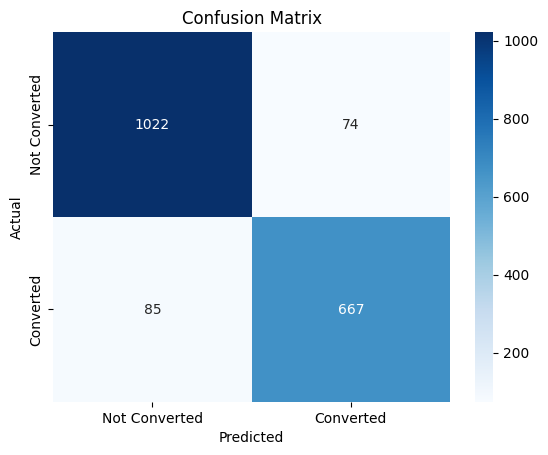

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1096
           1       0.90      0.89      0.89       752

    accuracy                           0.91      1848
   macro avg       0.91      0.91      0.91      1848
weighted avg       0.91      0.91      0.91      1848

Accuracy: 0.913961038961039
Precision: 0.9138236523773536
Recall: 0.913961038961039
F1 Score: 0.9138588881331455
Duration (s): 0.15274381637573242


In [12]:
# dt
st = time.time()
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())])

dt_model.fit(X_train, y_train)
et = time.time()

y_pred = dt_model.predict(X_test)

print_performance(y_test, y_pred, "DT", et, st)
model_cross_validation(dt_model, "dt", X_train)

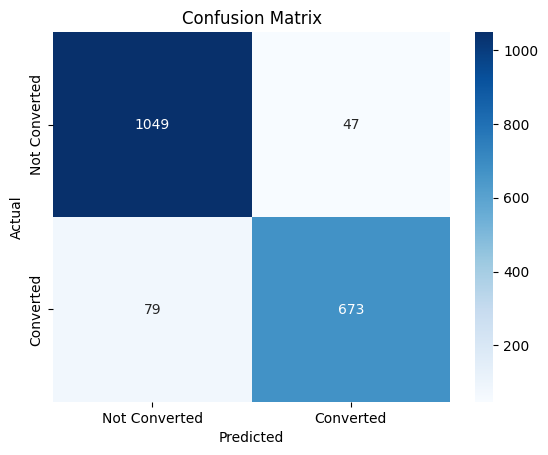

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1096
           1       0.93      0.89      0.91       752

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy: 0.9318181818181818
Precision: 0.9319005659431192
Recall: 0.9318181818181818
F1 Score: 0.9315675917763813
Duration (s): 2.0206918716430664


In [13]:
# rf
st = time.time()
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])

rf_model.fit(X_train, y_train)
et = time.time()

y_pred = rf_model.predict(X_test)

print_performance(y_test, y_pred, "RF", et, st)
model_cross_validation(rf_model, "rf", X_train)

C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


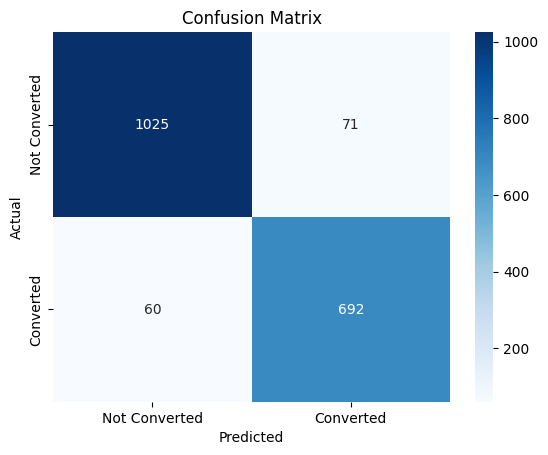

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1096
           1       0.91      0.92      0.91       752

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy: 0.9291125541125541
Precision: 0.9293372814702033
Recall: 0.9291125541125541
F1 Score: 0.9291911388034068
Duration (s): 8.4098060131073


C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
# nn
st = time.time()
nn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier())])

nn_model.fit(X_train, y_train)
et = time.time()

y_pred = nn_model.predict(X_test)

print_performance(y_test, y_pred, "NN", et, st)
model_cross_validation(nn_model, "nn", X_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_24764\335545301.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)


58/58 [==============================] - 0s 1ms/step


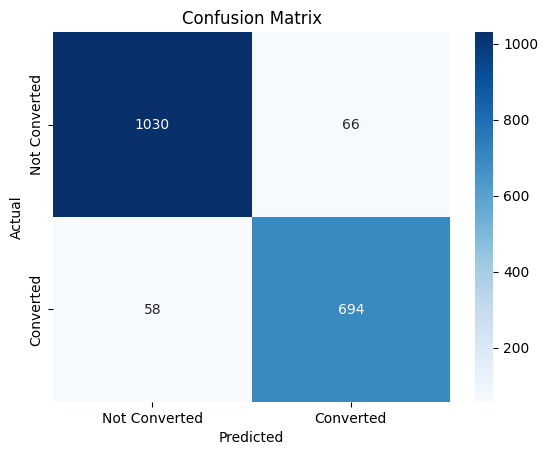

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1096
           1       0.91      0.92      0.92       752

    accuracy                           0.93      1848
   macro avg       0.93      0.93      0.93      1848
weighted avg       0.93      0.93      0.93      1848

Accuracy: 0.9329004329004329
Precision: 0.933045598622224
Recall: 0.9329004329004329
F1 Score: 0.932955052002671
Duration (s): 93.58001041412354
35/35 [==============================] - 0s 1ms/step


In [15]:
# honn
def higher_order_nn(input_dim, order):
    inputs = Input(shape=(input_dim,))
    x = inputs

    for i in range(order):
        x = Dense(64, activation="relu")(x) # input layer

    outputs = Dense(1, activation="sigmoid")(x) # output layer

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def create_honn_model():
    input_dim = X_train_preprocessed.shape[1]
    order = 2
    model = higher_order_nn(input_dim, order)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

st = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train).toarray()
honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)
honn_model.fit(X_train_preprocessed, y_train)
et = time.time()

X_test_preprocessed = preprocessor.transform(X_test).toarray()
y_pred = honn_model.predict(X_test_preprocessed)
y_pred = (y_pred > 0.5).astype(int)

print_performance(y_test, y_pred, "HONN", et, st)
model_cross_validation(honn_model, "honn", X_train_preprocessed)

In [16]:
# performance comparison table
print(tabulate(performance_result, headers = "firstrow", tablefmt = "outline"))

# save to csv file
df_performance = pd.DataFrame(performance_result[1:], columns = performance_result[0])
df_performance.to_csv('performance_overview.csv', index = False)

+-------------+------------+-------------+----------+------------+------------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1 Score |   Duration |
+=============+============+=============+==========+============+============+
| LR          |   0.92803  |    0.927979 | 0.92803  |   0.927828 |  0.0819483 |
| KNN         |   0.885823 |    0.885516 | 0.885823 |   0.885501 |  0.0275083 |
| SVM         |   0.929654 |    0.929559 | 0.929654 |   0.929578 |  0.882714  |
| NB          |   0.860931 |    0.860902 | 0.860931 |   0.860916 |  0.0488791 |
| DT          |   0.913961 |    0.913824 | 0.913961 |   0.913859 |  0.152744  |
| RF          |   0.931818 |    0.931901 | 0.931818 |   0.931568 |  2.02069   |
| NN          |   0.929113 |    0.929337 | 0.929113 |   0.929191 |  8.40981   |
| HONN        |   0.9329   |    0.933046 | 0.9329   |   0.932955 | 93.58      |
+-------------+------------+-------------+----------+------------+------------+
